In [7]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.8/251.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 13.1 MB/s eta 0:00:00


In [60]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from math import sqrt

from pykalman import KalmanFilter
from sklearn.linear_model import Ridge
from statsmodels.tsa.stattools import adfuller


In [61]:
import yfinance as yf
import pandas as pd

# Download data
msft_raw = yf.download("MSFT", start="2015-01-01", end="2024-01-01")

if isinstance(msft_raw.columns, pd.MultiIndex):
    # Select MSFT ticker level
    msft_raw = msft_raw.xs('MSFT', level=1, axis=1)

msft = msft_raw[['Close']].copy()
msft.rename(columns={'Close': 'price'}, inplace=True)

msft.dropna(inplace=True)

print(msft.head())
print(msft.columns)


/tmp/ipython-input-2432868883.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft_raw = yf.download("MSFT", start="2015-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed

Price           price
Date                 
2015-01-02  39.858459
2015-01-05  39.491917
2015-01-06  38.912289
2015-01-07  39.406696
2015-01-08  40.565956
Index(['price'], dtype='object', name='Price')


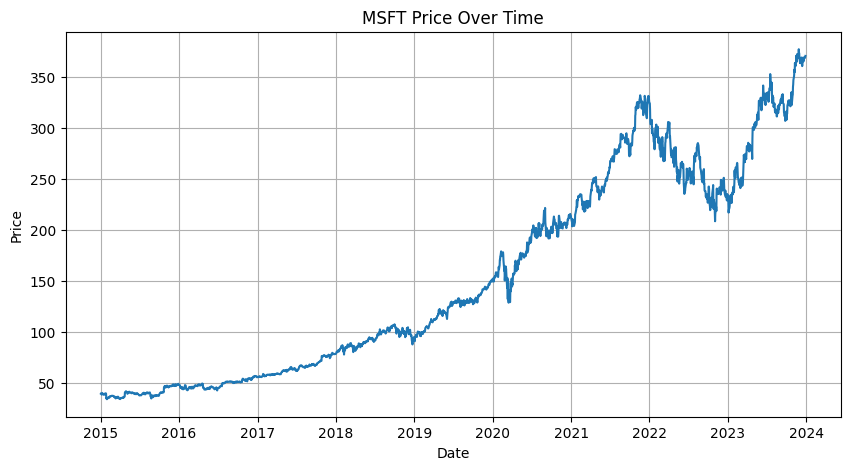

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(msft.index, msft['price'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("MSFT Price Over Time")
plt.grid(True)
plt.show()


In [63]:
import numpy as np
import pandas as pd

msft['log_return'] = np.log(msft['price'] / msft['price'].shift(1))
msft['lag_return'] = msft['log_return'].shift(1)

msft['ma_5']  = msft['price'].rolling(5).mean()
msft['ma_20'] = msft['price'].rolling(20).mean()
msft['ma_60'] = msft['price'].rolling(60).mean()

msft['roc_5'] = msft['price'].pct_change(5)

msft['ma_momentum'] = msft['ma_5'] - msft['ma_20']

msft['vol_20'] = msft['log_return'].rolling(20).std()

if 'Volume' in msft.columns:
    msft['vol_ma_20'] = msft['Volume'].rolling(20).mean()
    msft['volume_change'] = msft['Volume'].pct_change()

msft['price_ratio'] = msft['price'].shift(-1) / msft['price']
msft['current_ratio'] = msft['price'] / msft['price'].shift(1)
# Volatility regime
msft['vol_ratio'] = msft['vol_20'] / msft['vol_20'].rolling(60).mean()

# Long-term trend strength
msft['trend_60'] = msft['price'] / msft['ma_60'] - 1

# Distance from recent mean (mean-reversion signal)
msft['zscore_price'] = (
    msft['price'] - msft['ma_20']
) / msft['price'].rolling(20).std()

msft.dropna(inplace=True)

print(msft[['price', 'price_ratio']].head())

print(msft.head())
print(msft.columns)


Price           price  price_ratio
Date                              
2015-04-28  42.202442     0.997966
2015-04-29  42.116619     0.991438
2015-04-30  41.756027     1.000411
2015-05-01  41.773197     0.991369
2015-05-04  41.412651     0.986733
Price           price  log_return  lag_return       ma_5      ma_20  \
Date                                                                  
2015-04-28  42.202442    0.023254    0.003337  39.728331  36.732264   
2015-04-29  42.116619   -0.002036    0.023254  40.770518  37.092822   
2015-04-30  41.756027   -0.008599   -0.002036  41.680495  37.432777   
2015-05-01  41.773197    0.000411   -0.008599  41.816132  37.792046   
2015-05-04  41.412651   -0.008669    0.000411  41.852187  38.079205   

Price           ma_60     roc_5  ma_momentum    vol_20  price_ratio  \
Date                                                                  
2015-04-28  36.592257  0.152908     2.996067  0.024522     0.997966   
2015-04-29  36.707747  0.141196     3.677695

In [64]:
from statsmodels.tsa.stattools import adfuller

def run_adf(series, name):

    result = adfuller(series.dropna())

    print(f"ADF Test on {name}")
    print(f"p-value       : {result[1]:.4f}")

    if result[1] < 0.05:
        print("Conclusion    : Series is stationary (Reject H0)")
    else:
        print("Conclusion    : Series is non-stationary (Fail to Reject H0)")

    print("-" * 50)


# Run ADF tests
run_adf(msft['price'], "MSFT Price")
run_adf(msft['price_ratio'], "MSFT Price ratio")


ADF Test on MSFT Price
p-value       : 0.9889
Conclusion    : Series is non-stationary (Fail to Reject H0)
--------------------------------------------------
ADF Test on MSFT Price ratio
p-value       : 0.0000
Conclusion    : Series is stationary (Reject H0)
--------------------------------------------------


In [65]:

from pykalman import KalmanFilter
import numpy as np

def KalmanFilterTrend(price):
    n = len(price)

    # Normalized time index (good practice)
    t = np.arange(n) / n

    # Observation matrix: [1, t]
    obs_mat = np.vstack([np.ones(n), t]).T[:, np.newaxis]

    # --- KEY TUNING PARAMETERS ---
    delta = 1e-5          # smaller = smoother fair value
    trans_cov = delta / (1 - delta) * np.eye(2)

    obs_cov = np.var(price.values) * 0.5
    # higher obs noise → smoother fair value

    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=[price.iloc[0], 0],
        initial_state_covariance=np.eye(2),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=obs_cov,
        transition_covariance=trans_cov
    )

    state_means, _ = kf.filter(price.values)

    fair_value = state_means[:, 0]   # αₜ
    trend = state_means[:, 1]        # βₜ

    return fair_value, trend


msft['fair_value'], msft['trend'] = KalmanFilterTrend(msft['price'])
msft['deviation'] = msft['price'] - msft['fair_value']


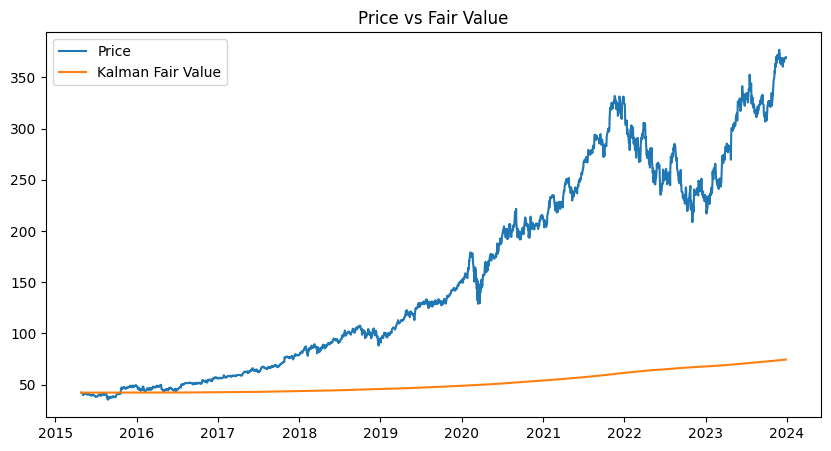

In [66]:
plt.figure(figsize=(10,5))
plt.plot(msft['price'], label='Price')
plt.plot(msft['fair_value'], label='Kalman Fair Value')
plt.legend()
plt.title("Price vs Fair Value")
plt.show()

In [67]:
features = [
    'lag_return',        # short-term memory
    'roc_5',             # momentum
    'ma_momentum',       # short vs medium trend
    'current_ratio',     # recent price movement
    'vol_20',            # absolute volatility
    'vol_ratio',         # volatility regime
    'trend_60',          # long-term trend
    'zscore_price'       # distance from mean
]
X = msft[features].values
y = msft['price_ratio'].values

kf_reg = KalmanFilter(
    transition_matrices=np.eye(len(features)),
    observation_matrices=X[:, np.newaxis, :],
    initial_state_mean=np.zeros(len(features)),
    initial_state_covariance=np.eye(len(features)),
    transition_covariance=0.001 * np.eye(len(features)),
    observation_covariance=0.01
)

state_means, _ = kf_reg.filter(y)


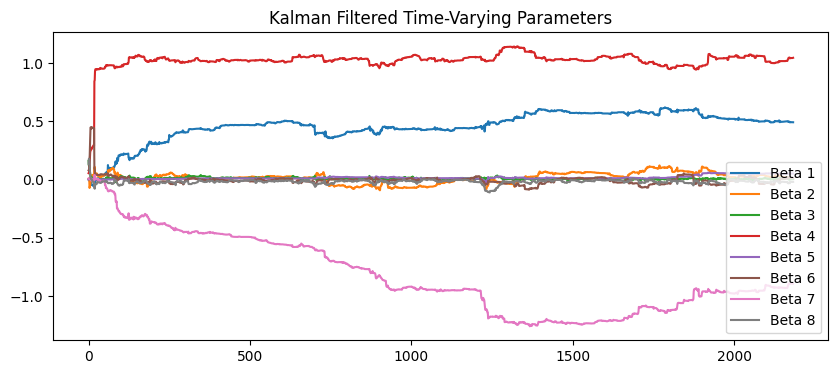

In [70]:
plt.figure(figsize=(10,4))

for i in range(state_means.shape[1]):
    plt.plot(state_means[:, i], label=f'Beta {i+1}')

plt.title("Kalman Filtered Time-Varying Parameters")
plt.legend()
plt.show()


In [71]:
features = ['lag_return', 'current_ratio','trend_60']
X = msft[features].values
y = msft['price_ratio'].values

kf_reg = KalmanFilter(
    transition_matrices=np.eye(len(features)),
    observation_matrices=X[:, np.newaxis, :],
    initial_state_mean=np.zeros(len(features)),
    initial_state_covariance=np.eye(len(features)),
    transition_covariance=0.001 * np.eye(len(features)),
    observation_covariance=0.01
)

state_means, _ = kf_reg.filter(y)


In [72]:
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import TimeSeriesSplit

X_ml = state_means[:-1]
y_ml = y[1:]

tscv = TimeSeriesSplit(n_splits=5)

alphas = np.logspace(-3, 1, 10)

ridge_cv = RidgeCV(
    alphas=alphas,
    cv=tscv,
    scoring="neg_mean_squared_error"
)

ridge_cv.fit(X_ml, y_ml)

best_alpha = ridge_cv.alpha_
print(f"Best alpha selected by CV: {best_alpha}")

# ----------------------------------------------------
# 3. Train final Ridge model using best alpha
# ----------------------------------------------------
model = Ridge(alpha=best_alpha)
model.fit(X_ml, y_ml)

# ----------------------------------------------------
# 4. Align MSFT data correctly and add predictions
# ----------------------------------------------------
n = len(X_ml)
msft = msft.iloc[-n:].copy()

msft['predicted_ratio'] = model.predict(X_ml)

# ----------------------------------------------------
# 5. (Optional) Inspect results
# ----------------------------------------------------
print(msft[['price', 'predicted_ratio']].head())
print(msft[['price', 'predicted_ratio']].tail())


Best alpha selected by CV: 0.46415888336127775
Price           price  predicted_ratio
Date                                  
2015-04-30  41.756027         0.998563
2015-05-01  41.773197         0.998357
2015-05-04  41.412651         0.998378
2015-05-05  40.863216         0.998365
2015-05-06  39.730034         0.998366
Price            price  predicted_ratio
Date                                   
2023-12-21  368.052399         1.000515
2023-12-22  369.077118         1.000567
2023-12-26  369.155945         1.000618
2023-12-27  368.574615         1.000652
2023-12-28  369.766815         1.000650


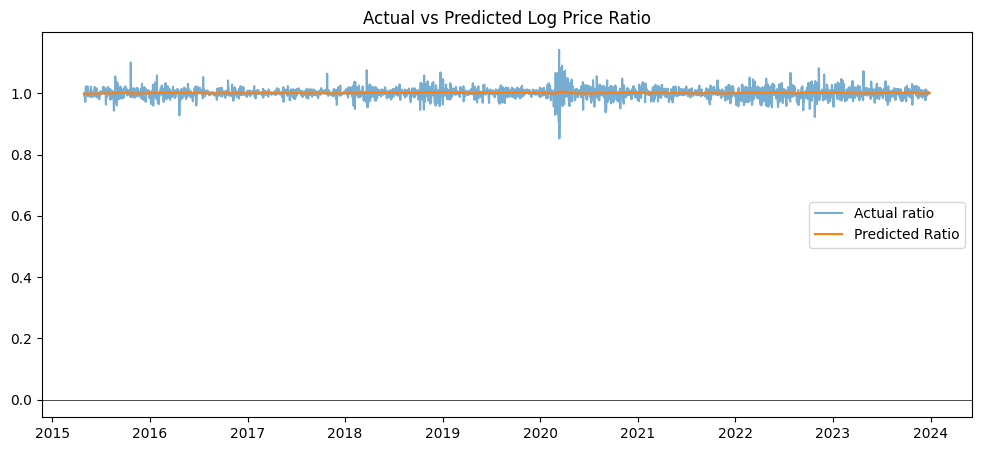

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(msft.index, msft['price_ratio'], label='Actual ratio', alpha=0.6)
plt.plot(msft.index, msft['predicted_ratio'], label='Predicted Ratio', alpha=1)
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()
plt.title('Actual vs Predicted Log Price Ratio')
plt.show()

In [74]:
threshold = np.std(msft['predicted_ratio'])


msft['signal'] = 0

msft.loc[
    msft['predicted_ratio'] > msft['current_ratio'] + threshold,
    'signal'
] = 1   # Buy

msft.loc[
    msft['predicted_ratio'] < msft['current_ratio'] - threshold,
    'signal'
] = -1  # Sell


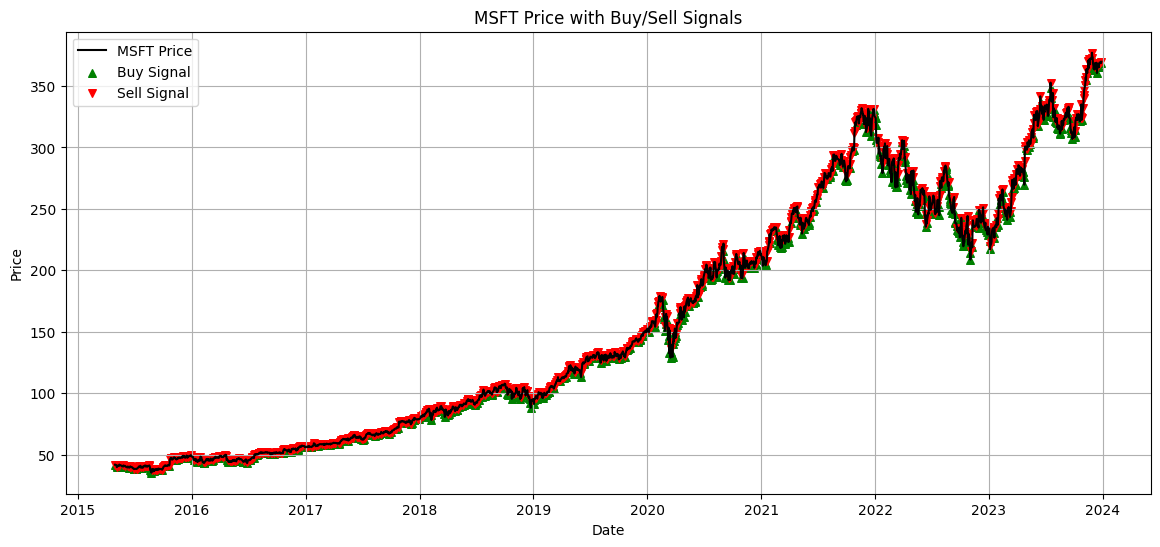

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Plot price
plt.plot(msft.index, msft['price'], label='MSFT Price', color='black')

# Buy signals
plt.scatter(
    msft.index[msft['signal'] == 1],
    msft['price'][msft['signal'] == 1],
    color='green',
    label='Buy Signal',
    marker='^',
    s=30
)

# Sell signals
plt.scatter(
    msft.index[msft['signal'] == -1],
    msft['price'][msft['signal'] == -1],
    color='red',
    label='Sell Signal',
    marker='v',
    s=30)

plt.title("MSFT Price with Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

plt.show()


In [76]:
msft['position'] = msft['signal'].shift(1)
msft['position'] = msft['position'].fillna(0)
msft['returns'] = msft['price'].pct_change()
msft['strategy_returns'] = msft['position'] * msft['returns']
transaction_cost = 0.0005  # 5 basis points per trade

# Identify trades (position changes)
msft['trade'] = msft['position'].diff().abs()

# Apply transaction costs
msft['strategy_returns'] -= msft['trade'] * transaction_cost

msft['cum_strategy'] = (1 + msft['strategy_returns']).cumprod()
msft['cum_buy_hold'] = (1 + msft['returns']).cumprod()

def sharpe_ratio(returns):
    returns = returns.dropna()
    if returns.std() == 0:
        return 0.0
    return (returns.mean() / returns.std()) * sqrt(252)
strategy_sharpe = sharpe_ratio(msft['strategy_returns'])
buyhold_sharpe = sharpe_ratio(msft['returns'])
def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()
strategy_mdd = max_drawdown(msft['cum_strategy'])
buyhold_mdd = max_drawdown(msft['cum_buy_hold'])
trade_returns = msft.loc[msft['trade'] > 0, 'strategy_returns']

wins = (trade_returns > 0).sum()
losses = (trade_returns < 0).sum()

win_loss_ratio = wins / losses if losses != 0 else np.nan

strategy_total_return = msft['cum_strategy'].iloc[-1] - 1
buyhold_total_return = msft['cum_buy_hold'].iloc[-1] - 1




In [79]:
print("STRATEGY PERFORMANCE")
print("-----------------------")
print(f"Cumulative Return   : {strategy_total_return:.2%}")
print(f"Sharpe Ratio        : {strategy_sharpe:.2f}")
print(f"Maximum Drawdown    : {strategy_mdd:.2%}")
print(f"Win/Loss Ratio      : {win_loss_ratio:.2f}")

print("BUY & HOLD (MSFT)")
print("-----------------------")
print(f"Cumulative Return   : {buyhold_total_return:.2%}")
print(f"Sharpe Ratio        : {buyhold_sharpe:.2f}")
print(f"Maximum Drawdown    : {buyhold_mdd:.2%}")


STRATEGY PERFORMANCE
-----------------------
Cumulative Return   : 254.93%
Sharpe Ratio        : 0.67
Maximum Drawdown    : -33.50%
Win/Loss Ratio      : 0.71
BUY & HOLD (MSFT)
-----------------------
Cumulative Return   : 785.54%
Sharpe Ratio        : 1.05
Maximum Drawdown    : -37.15%


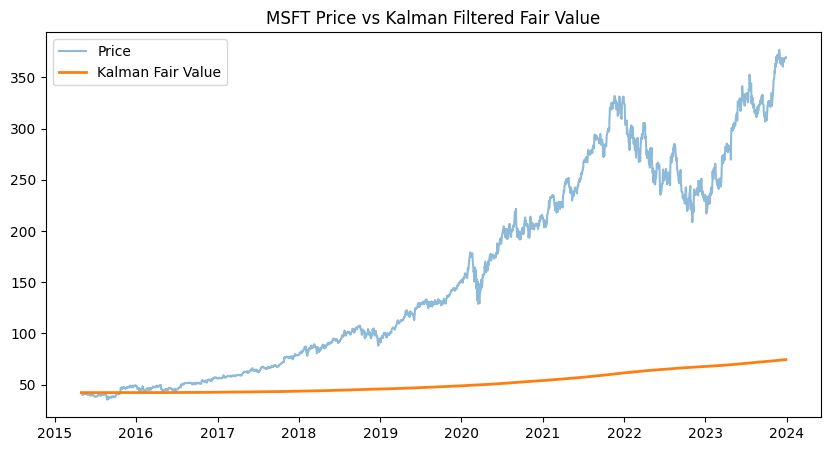

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(msft['price'], label='Price', alpha=0.5)
plt.plot(msft['fair_value'], label='Kalman Fair Value', linewidth=2)
plt.legend()
plt.title("MSFT Price vs Kalman Filtered Fair Value")
plt.show()


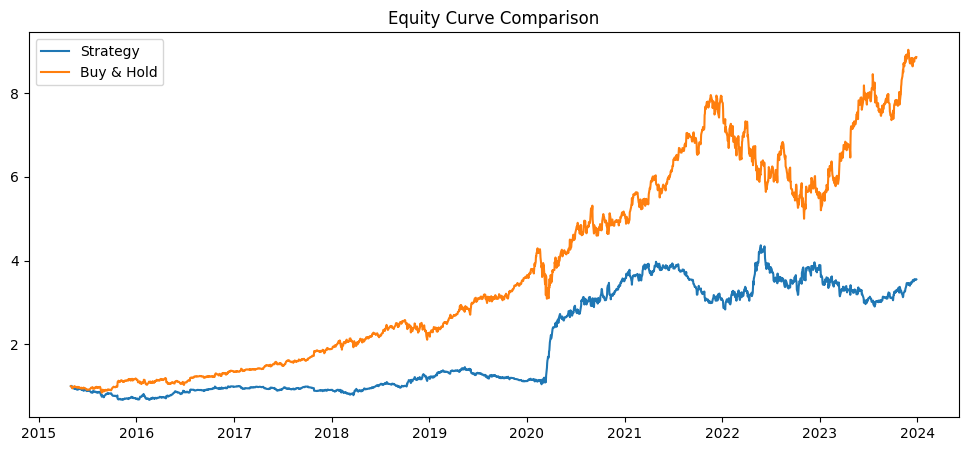

In [84]:
plt.figure(figsize=(12,5))
plt.plot(msft['cum_strategy'], label='Strategy')
plt.plot(msft['cum_buy_hold'], label='Buy & Hold')
plt.title("Equity Curve Comparison")
plt.legend()
plt.show()
